In [1]:
import matplotlib.pyplot as plt

## 关键点检测和描述

1.图像读取和灰度化：

In [5]:
#将RGB图像转换为灰度图像
def RGB2GRAY(image):
    gray=[]
    height = len(image)
    width = len(image[0])
    for i in range(height):
        row=[]
        for j in range(width):
            r,g,b = image[i][j]
            I = 0.2989*r +0.587*g + 0.114*b
            row.append(I)
        gray.append(row)
    return gray

In [3]:
def read_image(filename):
    image =plt.imread(filename)
    image = image.tolist()
    if len(image[0][0]) == 3:
        image_gray = RGB2GRAY(image)
    else:
        image_gray = image
    return image_gray

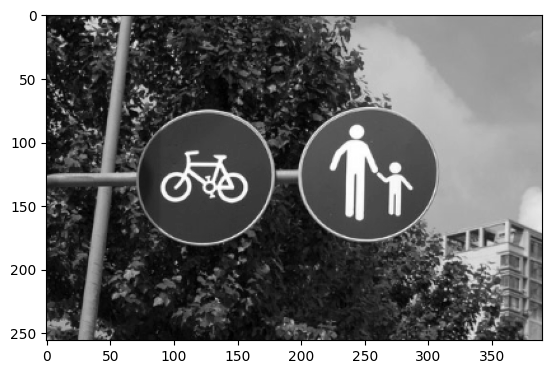

In [6]:
#使用matplotlib显示灰度图像
img = read_image('test_sobel.png')
plt.imshow(img,cmap='gray')

In [7]:
#计算Sobel算子
def compute_sobel_operator(image_gray):
    height = len(image_gray)
    width = len(image_gray[0])

    Gx = [[-1,0,1],
          [-2,0,2],
          [-1,0,1]]
    
    Gy = [[-1,-2,-1],
          [0,0,0],
          [1,2,1]]
    
    kernel_height = len(Gx)
    kernel_width = len(Gx[0])

    Ix = []
    Iy = []
    
    for i in range(height-kernel_height+1):
        row_x=[]
        row_y=[]
        for j in range(width-kernel_width+1):
            Sum_x = 0
            Sum_y = 0
            for x in range(kernel_height):
                for y in range(kernel_width):
                    pixel_x = image_gray[x+i][y+j]*Gx[x][y]
                    pixel_y = image_gray[x+i][y+j]*Gy[x][y]
                    Sum_x +=pixel_x
                    Sum_y +=pixel_y
            row_x.append(Sum_x)
            row_y.append(Sum_y)
        Ix.append(row_x)
        Iy.append(row_y)

    return Ix,Iy

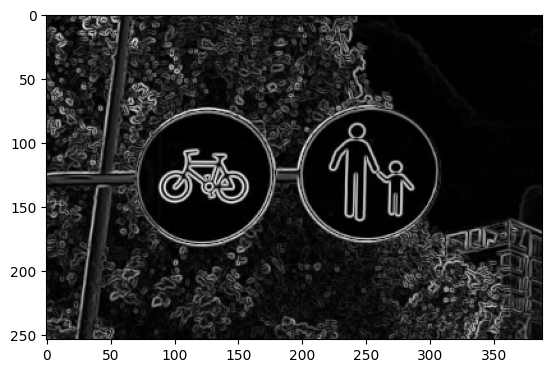

In [9]:
#调用numpy来测试
import numpy as np
X,y = compute_sobel_operator(img)
x = np.array(X)
y = np.array(y)
G = np.hypot(x,y)
G = (G/G.max()) * 255
plt.imshow(G,cmap = 'gray')
plt.show()

In [10]:
def compute_gradient_products(Ix,Iy):
    height = len(Ix)
    width = len(Ix[0])

    Ixx = []
    Iyy = []
    Ixy = []

    for i in range(height):
        row_xx = []
        row_yy = []
        row_xy = []
        for j in range(width):
            ix = Ix[i][j]
            iy = Iy[i][j]
            ixx = ix * ix
            iyy = iy * iy
            ixy = ix* iy
            row_xx.append(ixx)
            row_yy.append(iyy)
            row_xy.append(ixy)
        Ixx.append(row_xx)
        Ixy.append(row_xy)
        Iyy.append(row_yy)
    return Ixx,Iyy,Ixy

$
G(x,y) = \frac{1}{{2\pi\sigma^2}} \exp \left( -\frac{x^2+y^2}{2\sigma^2} \right)
$

### Применение гауссова фильтра

Новое значение пикселя вычисляется с помощью свёртки:

$
I_{\text{new}}(x, y) = \sum_{i=-k}^{k} \sum_{j=-k}^{k} G(i, j) \cdot I(x + i, y + j)
$

где $ k $ определяется размером фильтра (обычно $ k = 3 $ или $ k = 5 $).


In [11]:
import math

def gaussian_kernal(size,sigma):
    kernel = []
    center = size // 2
    sum_val = 0

    for i in range(size):
        row = []
        for j in range(size):
            x = j-center
            y = i-center
            #x 和 y 是相对于中心的坐标，因此需要减去 center。
            exponent = -(x**2 + y**2) / (2*sigma**2)
            value = (1/(2*math.pi*sigma**2))*math.exp(exponent)
            row.append(value)
            sum_val += value
        kernel.append(row)
    #归一化核
    for i in range(size):
        for j in range(size):
            kernel[i][j] /=sum_val
    
    return kernel

In [12]:
def convolve(image,kernel):
    height = len(image)
    width = len(image[0])
    kernel_size = len(kernel)

    result = [[0 for _ in range(width-kernel_size+1)]for _ in range(height-kernel_size+1)]

    for i in range(height-kernel_size+1):
        for j in range(width-kernel_size+1):
            sum_val = 0
            for m in range(kernel_size):
                for n in range(kernel_size):
                    pixel = image[i+m][j+n]*kernel[m][n]
                    sum_val+=pixel
            result[i][j] = sum_val
    
    return result



$𝑅= det(𝑀)−𝑘*(trace(𝑀))^2$<br>
$det(M)=I_x^2 * I_y^2 -(I_xI_y)^2$<br>
$ trace(M) = I_x^2 + I_y^2$

In [13]:
def compute_R(Sxx,Syy,Sxy,k=0.04):
    height = len(Sxx)
    width = len(Sxx[0])

    R = [[0 for _ in range(width)]for _ in range(height)]

    for i in range(height):
        for j in range(width):
            det = Sxx[i][j] * Syy[i][j] - Sxy[i][j]**2
            trace = Sxx[i][j] + Syy[i][j]
            R[i][j] = det - k*(trace**2)
    return R

In [14]:
#整合之前的几个函数，实现harris角点检测
def harris_corner_detection(image_gray,k=0.04,gussian_size=3,sigma=1.5):
    Ix,Iy = compute_sobel_operator(image_gray)
    Ixx,Iyy,Ixy = compute_gradient_products(Ix,Iy)
    kernel = gaussian_kernal(gussian_size,sigma)
    Sxx = convolve(Ixx,kernel)
    Syy = convolve(Iyy,kernel)
    Sxy = convolve(Ixy,kernel)
    R = compute_R(Sxx,Syy,Sxy,k)
    return R

非极大值抑制和阈值处理

In [15]:
def non_maximum_suppression(R,threshold):
    height = len(R)
    width = len(R[0])
    corners = []

    for i in range(1,height-1):
        for j in range(1,width-1):
            #使用非极大值抑制检查该像素的 3x3 邻域
            #R[i][j]就是3x3矩阵中心点坐标
            #如果当前像素在邻域内具有最大响应值，则认为其为角点。
            if R[i][j] > threshold:
                local_max = True
                for m in range(-1,2):
                    for n in range(-1,2):
                        if R[i+m][j+n] > R[i][j]:
                            local_max = False
                            break
                    if not local_max:
                        break
#将该像素的位置 (i, j) 和对应的响应值 R[i][j] 添加到 corners 字典中
                if local_max:
                    corners.append({'x':j,'y':i,'response':R[i][j]})
    return corners

生成特征描述符

In [42]:
def compute_gradient_magnitude_orientation(Ix,Iy):
    height = len(Ix)
    width = len(Ix[0])
    magnitude = [[0 for _ in range(width)]for _ in range(height)]
    orientation = [[0 for _ in range(width)]for _ in range(height)]

    for y in range(height):
        for x in range(width):
            gx = Ix[y][x]
            gy = Iy[y][x]
            magnitude[y][x] = (gx**2+gy**2)**0.5
            orientation[y][x] = (math.degrees(math.atan2(gy,gx))+360)%360
    return magnitude,orientation

def compute_keypoint_orientations(keypoints,magnitude,orientation):
    for kp in keypoints:
        x = kp['x']
        y = kp['y']
        #定义邻域半径
        radius = 8
        hist_bins = 36
        hist = [0]*hist_bins

        for i in range(-radius,radius+1):
            for j in range(-radius,radius+1):
                xj = x+j
                yi = y+i
                #限制范围
                if 0 <= xj <len(magnitude[0]) and 0 <= yi <len(magnitude):
                    #计算距离高斯权重
                    distance = (i ** 2 + j ** 2) ** 0.5
                    if distance > radius:
                        continue
                    weight = math.exp(-(distance ** 2)) / (2*(radius / 2)**2)
                    #获取梯度幅值和方向
                    mag = magnitude[yi][xj] * weight
                    angle = orientation[yi][xj]
                    #计算直方图索引
                    bin_idx = int(angle / 10) % hist_bins
                    hist[bin_idx] += mag
        #找到直方图中最大值
        max_bin_value = max(hist)
        max_bin_index = hist.index(max_bin_value)
        kp_angle = max_bin_index*10 #每个桶10°
        kp['angle'] = kp_angle

In [48]:
def compute_sift_descriptors(image_gray, keypoints, magnitude, orientation):
    height = len(image_gray)
    width = len(image_gray[0])
    radius = 8
    descriptors = []

    # 检查输入数组大小
    assert len(magnitude) == height and len(magnitude[0]) == width, "Magnitude array size mismatch"
    assert len(orientation) == height and len(orientation[0]) == width, "Orientation array size mismatch"

    for kp in keypoints:
        x = kp['x']
        y = kp['y']
        
        # 跳过靠近边缘的关键点
        if (x < radius or x >= width - radius or 
            y < radius or y >= height - radius):
            continue
            
        descriptor = [0] * 128
        kp_angle = kp.get('angle', 0)

        for sub_y in range(-radius, radius + 1):
            for sub_x in range(-radius, radius + 1):
                xi = x + sub_x
                yj = y + sub_y
                if 0 <= xi < width and 0 <= yj < height:
                    bin_x = int((sub_x + radius) / 4)
                    bin_y = int((sub_y + radius) / 4)
                    if 0 <= bin_x < 4 and 0 <= bin_y < 4:
                        mag = magnitude[yj][xi]
                        angle = orientation[yj][xi] - kp_angle
                        angle = (angle + 360) % 360

                        bin_orientation = int(angle / 45) % 8
                        index = (bin_y * 4 + bin_x) * 8 + bin_orientation
                        descriptor[index] += mag

        # 归一化
        norm = sum([v ** 2 for v in descriptor]) ** 0.5
        if norm > 0:
            descriptor = [v / norm for v in descriptor]
        
        kp['descriptor'] = descriptor
        descriptors.append(kp)

    return descriptors

In [52]:
Ix,Iy = compute_sobel_operator(img)
print(len(Ix))
r = harris_corner_detection(img)
# 设定阈值为响应值最大值的 20%
max_response = max([max(row) for row in r])
threshold = max_response * 0.2 
#非极大值抑制和阈值处理计算角点
keypoints = non_maximum_suppression(r, threshold)
magnitude, orientation = compute_gradient_magnitude_orientation(Ix, Iy)
    # 计算关键点的主要方向
compute_keypoint_orientations(keypoints, magnitude, orientation)
keypoints

254


[{'x': 38, 'y': 1, 'response': 1.5411138906086437, 'angle': 50},
 {'x': 51, 'y': 1, 'response': 2.804533731344755, 'angle': 90},
 {'x': 32, 'y': 2, 'response': 1.7717987346998765, 'angle': 10},
 {'x': 43, 'y': 2, 'response': 3.3709126243047605, 'angle': 110},
 {'x': 45, 'y': 3, 'response': 1.6710567008243502, 'angle': 110},
 {'x': 29, 'y': 4, 'response': 2.7153223544248024, 'angle': 60},
 {'x': 52, 'y': 4, 'response': 3.0008623174390925, 'angle': 270},
 {'x': 55, 'y': 5, 'response': 1.210172362725333, 'angle': 0},
 {'x': 39, 'y': 6, 'response': 1.0756333183637943, 'angle': 190},
 {'x': 28, 'y': 7, 'response': 1.6500715916126143, 'angle': 330},
 {'x': 33, 'y': 13, 'response': 2.531343942751931, 'angle': 280},
 {'x': 36, 'y': 14, 'response': 2.0564840442843835, 'angle': 280},
 {'x': 46, 'y': 14, 'response': 1.7491856503241603, 'angle': 270},
 {'x': 9, 'y': 15, 'response': 3.428195381361573, 'angle': 50},
 {'x': 7, 'y': 16, 'response': 2.1012772211240094, 'angle': 310},
 {'x': 69, 'y': 19

In [51]:
    # 生成 SIFT 特征描述符
# 在调用函数之前，打印尺寸信息
print("Image size:", len(img), len(img[0]))
print("Magnitude size:", len(magnitude), len(magnitude[0]))
print("Orientation size:", len(orientation), len(orientation[0]))
descriptors = compute_sift_descriptors(img, keypoints, magnitude, orientation)
descriptors

Image size: 256 390
Magnitude size: 254 388
Orientation size: 254 388


AssertionError: Magnitude array size mismatch

In [194]:
def draw_keypoints(image_gray, keypoints):
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1)
    ax.imshow(image_gray, cmap='gray')
    
    for kp in keypoints:
        x = kp['x']
        y = kp['y']
        rect = patches.Rectangle((x - 1.5, y - 1.5), 3, 3, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()
 


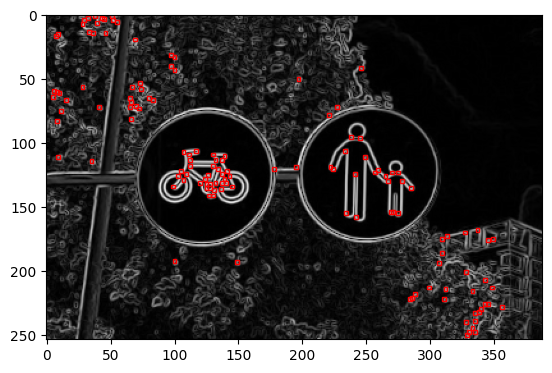

In [196]:
draw_keypoints(G,keypoints)